## Reccurent Neural Net from Scratch

### Introduction to RNN

RNNs are a class of neural networks that allow previous outputs to be used as inputs while having hidden states. These hidden states are later used combined with additional inputs as the **next input**. 

You can think of the **additional inputs as being concatenated to the end of the “normal” inputs** to the previous layer. For example, if you have a hidden layer of 10, and an input layer of 256, then in the next round you will have a layer of **10 + 256 = 266**.


<img src="pic/diags.jpg" width=500>


The core reason that RNNs are so exciting is that they allow us to operate over sequences of vectors.

### Pros and Cons of RNN

**Advantages**
* Possibility of processing input of any length.
* Model size not increasing with size of input.
* Computation takes into account historical information.
* Weights are shared across time.

**Disadvantages**
* Suffer from vanishing gradient problem.
* Computation being slow.
* Cannot consider any future input for the current state.

### What is the Vanishing Gradient Problem?
Vanishing Gradient problem occurs while training neural networks with **gradient-based learning methods and backpropagation due to the vanishingly small gradient**. That is, the gradient is too small to be updated; worse yet, **the model might stop learning and updating parameters**.  

<img src="pic/vgp_pic.png" width=500>

Source: [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257)

The vanishing gradient problem is solved by another variation of RNNs: **the Long Short Term Networks (LSTM)**. 


### Code Example

In [7]:
import io
import os
import unicodedata
import string
import glob
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Define Helper Function

In [24]:

# Capture all alphabets
allLetters = string.ascii_letters + ".,;"
N_Letters = len(allLetters)

def unicode_to_ascii(s):
    """
    Helper function to turn unicode string to plan ASCII to remove special character
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allLetters
    )

def load_data():
    """
    Helper function to load dataset in all the text files. 
    """
    categroy_lines = {}
    all_categories = []
    def find_files(path):
        return glob.glob(path)
    
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        categroy_lines[category] = lines
    return categroy_lines, all_categories    

def letter_to_index(letter):
    """
    Find the index of the letter
    """
    return allLetters.find(letter)

def letter_to_tensor(letter):
    """
    Transform letter into PyTorch Tensor
    """
    tensor = torch.zeros(1, N_Letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    """
    Implement one-hot-encoding to transform letters into training
    """
    tensor = torch.zeros(len(line), 1, N_Letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):
    """
    Generate random training example for the RNN.
    """
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

def category_from_output(output):
    """
    Return the category with the highest probabilities
    """
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

### Construct & Train Simple RNN

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim = 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
category_lines, all_categories = load_data()
n_hidden = 128
rnn = RNN(N_Letters, n_hidden, n_categories)

In [31]:
## Train RNN

criterion = nn.NLLLoss() # negative log likelihood loss
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    """
    Main Training Function for the Recurrent Neural Net 
    """
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [33]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {i/n_iters*100:.2f} {loss:.4f} {line} / {guess} {correct}")

5000 5.00 2.8650 Earle / French WRONG (English)
10000 10.00 1.9360 Whyte / Japanese WRONG (Scottish)
15000 15.00 2.9423 Bonnay / Czech WRONG (French)
20000 20.00 2.3948 Machado / Portuguese WRONG (Spanish)
25000 25.00 0.9573 Murray / Scottish CORRECT
30000 30.00 2.7294 Derrick / Czech WRONG (German)
35000 35.00 3.2486 Keal / Chinese WRONG (English)
40000 40.00 1.7130 Adamou / Portuguese WRONG (Greek)
45000 45.00 2.8204 Belmonte / Italian WRONG (Spanish)
50000 50.00 1.0531 Song / Chinese WRONG (Korean)
55000 55.00 0.4739 Beringer / French CORRECT
60000 60.00 0.8627 Bueren / Dutch CORRECT
65000 65.00 0.5837 Koury / Arabic CORRECT
70000 70.00 3.9287 Gro / Chinese WRONG (German)
75000 75.00 0.3599 Abrami / Italian CORRECT
80000 80.00 1.1179 Ruvelas / Greek CORRECT
85000 85.00 0.8274 Marie / French CORRECT
90000 90.00 2.8132 Lupo / Portuguese WRONG (Italian)
95000 95.00 0.0188 Papoutsis / Greek CORRECT
100000 100.00 1.0166 Sha / Korean WRONG (Chinese)


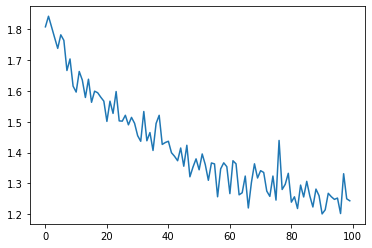

In [34]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [40]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [41]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)

Input:Patrick

> Patrick
Czech
Input:Patrick

> Patrick
Czech
Input:Jenny

> Jenny
Scottish
Input:Marie

> Marie
French
Input:Ruvelas

> Ruvelas
Greek
Input:quit


### Ending Notes
1. **Why choose LogSoftmax over Softmax?**? [[Source]](https://stats.stackexchange.com/questions/174481/why-to-optimize-max-log-probability-instead-of-probability)
    * **Simplify calculation** -- logarithm of the probability of multiple joint probabilities simplifies to the sum of the logarithms of the individual probabilities.
    * **Deal with exponentials** -- logarithm takes good care of exponential terms.
    * **Numerical stability** -- to prevent from minute floating number
    * **Monotomic transformation** -- logarithm is a monotonic transformation that preserves the locations of the extrema.
    
    
    
2. **What is Negative Log-Likelihood and why**? [[Source]](https://datascieance.stackexchange.com/questions/94100/negative-log-likelihood-not-the-same-as-cross-entropy)
    * Any loss consisting of a **negative log-likelihood** is a **cross-entropy between the empirical distribution deﬁned by the training set** and **the probability distribution deﬁned by model**.




### Source
[PyTorch RNN Tutorial by Python Engineer](https://www.youtube.com/watch?v=WEV61GmmPrk&ab_channel=PythonEngineer)

[Kaggle -- Intro to Recurrent Neural Networks LSTM | GRU](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)